In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#keras imports
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, CuDNNLSTM
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import TensorBoard, EarlyStopping

In [5]:
df = pd.read_csv('spam.csv', delimiter=',', encoding='latin-1', usecols=['v1','v2'])
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
v1    5572 non-null object
v2    5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


Text(0, 0.5, 'Number of han and SPAM messages')

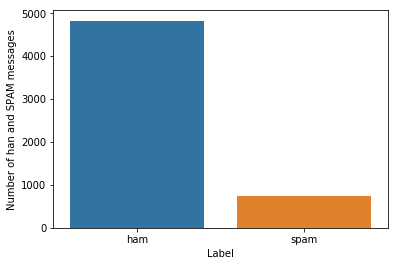

In [8]:
sns.countplot(df.v1)
plt.xlabel('Label')
plt.ylabel('Number of han and SPAM messages')

In [12]:
X = df.v2
y = df.v1
le = LabelEncoder()
y = le.fit_transform(y)
Y = y.reshape(-1,1) # important

In [11]:
Y

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

In [15]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)

In [16]:
sequences_matrix

array([[  0,   0,   0, ...,   5, 803, 804],
       [  0,   0,   0, ...,   5,  53,   5],
       [  0,   0,   0, ...,   0, 321,  36],
       ...,
       [  0,   0,   0, ..., 245, 221, 238],
       [  0,   0,   0, ...,   7, 403,  13],
       [  0,   0,   0, ..., 192,  65,  53]])

In [17]:
sequences_matrix.shape

(4457, 150)

In [22]:
#RNN

def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = CuDNNLSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [23]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 64)                29696     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_3 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
__________

In [24]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 3565 samples, validate on 892 samples
Epoch 1/10
3565/3565 [==============================] - 3s 942us/step - loss: 0.3442 - acc: 0.8687 - val_loss: 0.1569 - val_acc: 0.9462
Epoch 2/10
3565/3565 [==============================] - 0s 100us/step - loss: 0.1015 - acc: 0.9750 - val_loss: 0.0597 - val_acc: 0.9843
Epoch 3/10
3565/3565 [==============================] - 0s 98us/step - loss: 0.0497 - acc: 0.9865 - val_loss: 0.0505 - val_acc: 0.9832
Epoch 4/10
3565/3565 [==============================] - 0s 102us/step - loss: 0.0365 - acc: 0.9910 - val_loss: 0.0518 - val_acc: 0.9832


In [25]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [26]:
accr = model.evaluate(test_sequences_matrix,Y_test)

1115/1115 [==============================] - 0s 352us/step


In [27]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.052
  Accuracy: 0.984
